DATASET for BCH(15, 7, 2)

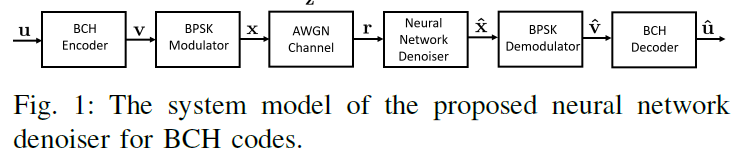

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import random
import csv
import pandas as pd
import itertools
from collections import Counter

BPSK Modulation

In [56]:
def bin_to_sign(x):
    return 1 - 2 * x

def sign_to_bin(x):
    return 0.5 * (1 - x)

messages = []
codewords = []

with open("encoded_messages.csv", mode="r") as file:
    csv_reader = csv.reader(file)

    header = next(csv_reader)
    
    for row in csv_reader:
        messages.append(row[0])
        codewords.append(row[1])


messages_tensor = [torch.tensor(list(map(int, msg)), dtype=torch.float32) for msg in messages]
codewords_tensor = [torch.tensor(list(map(int, cdw)), dtype=torch.float32) for cdw in codewords]

AWGN

In [57]:
def add_awgn(sign_message, Eb_N0):
    # Oblicz moc sygnału
    sign_power = torch.mean(sign_message ** 2).item()  # Moc sygnału
    
    # Przekształcenie Eb/N0 do skali liniowej
    Eb_N0_linear = 10 ** (Eb_N0 / 10)
    
    # Oblicz N0 (gęstość mocy szumu)
    N0 = sign_power / Eb_N0_linear  # Moc szumu (N0)
    
    # Generowanie szumu AWGN
    noise = torch.normal(0, (N0 / 2) ** 0.5, sign_message.shape)  # Szum gaussowski
    
    # Dodanie szumu do sygnału
    noisy_signal = sign_message + noise
    return noisy_signal

Train dataset

In [58]:
Eb_N0_train = 0
nois_results_per_message = 782
noisy_codeword = []

train_data = []

for msg, cdw in zip(messages_tensor, codewords_tensor):
    sign_codeword = bin_to_sign(cdw)  # Konwersja na sygnał BPSK

    for i in range(nois_results_per_message):
        awgn_codeword = add_awgn(sign_codeword, Eb_N0_train)  # Dodanie szumu AWGN
        awgn_binary = (awgn_codeword < 0).float()
        
        # Zamiana tensora na string dla każdej kolumny
        tensor_string_msg = ', '.join(map(str, msg.tolist()))
        tensor_string_cdw = ', '.join(map(str, cdw.tolist()))
        tensor_string_sign = ', '.join(map(str, sign_codeword.tolist()))
        tensor_string_awgn = ', '.join(map(str, awgn_codeword.tolist()))
        tensor_string_awgn_bin = ', '.join(map(str, awgn_binary.tolist()))

        # Dodaj do `data` jako nowy wiersz
        train_data.append([tensor_string_msg, tensor_string_cdw, tensor_string_sign, tensor_string_awgn, tensor_string_awgn_bin])


columns = ['message', 'codeword', 'sign_codeword', 'awgn_sign_codeword_0', 'awgn_sign_codeword_binary_0']
df = pd.DataFrame(train_data, columns=columns)
df = df.drop_duplicates()
# Zapis do pliku CSV
df.to_csv('train_dataset.csv', index=False)
        
# Print wszystkie wiersze (bez nagłówków)
df = pd.read_csv('train_dataset.csv')

# Pobierz liczbę wierszy
row_count = len(df)
print(f'train_dataset.csv created: {row_count}, Eb/N0 = {Eb_N0_train} dB')

train_dataset.csv created: 100096, Eb/N0 = 0 dB


In [59]:
def create_test_dataset(msg_t, cdw_t, Eb_N0_test, nois_results_per_message):
    test_data = []
    
    for msg, cdw in zip(msg_t, cdw_t):
        sign_codeword = bin_to_sign(cdw)  # Konwersja na sygnał BPSK
    
        for i in range(nois_results_per_message):
            awgn_codeword = add_awgn(sign_codeword, Eb_N0_test)  # Dodanie szumu AWGN
            awgn_binary = (awgn_codeword < 0).float()
            
            # Zamiana tensora na string dla każdej kolumny
            tensor_string_msg = ', '.join(map(str, msg.tolist()))
            tensor_string_cdw = ', '.join(map(str, cdw.tolist()))
            tensor_string_sign = ', '.join(map(str, sign_codeword.tolist()))
            tensor_string_awgn = ', '.join(map(str, awgn_codeword.tolist()))
            tensor_string_awgn_bin = ', '.join(map(str, awgn_binary.tolist()))
    
            # Dodaj do `data` jako nowy wiersz
            test_data.append([tensor_string_msg, tensor_string_cdw, tensor_string_sign, tensor_string_awgn, tensor_string_awgn_bin])
    
    
    columns = ['message', 'codeword', 'sign_codeword', f'awgn_sign_codeword_{elem}', f'awgn_sign_codeword_binary_{elem}']
    df = pd.DataFrame(test_data, columns=columns)
    df = df.drop_duplicates()
    # Zapis do pliku CSV
    df.to_csv(f'test_dataset/test_dataset_{elem}.csv', index=False)
            
    # Print wszystkie wiersze (bez nagłówków)
    df = pd.read_csv(f'test_dataset/test_dataset_{elem}.csv')
    
    # Pobierz liczbę wierszy
    row_count = len(df)
    print(f'test_dataset/test_dataset_{elem}.csv created: {row_count}, Eb/N0 = {elem} dB')

Test dataset

In [60]:
Eb_N0_test = [0, 1, 2, 3, 4, 5, 6, 7]  # dB
nois_results_per_message = 977

for elem in Eb_N0_test:
    create_test_dataset(messages_tensor, codewords_tensor, elem, nois_results_per_message)

test_dataset/test_dataset_0.csv created: 125056, Eb/N0 = 0 dB
test_dataset/test_dataset_1.csv created: 125056, Eb/N0 = 1 dB
test_dataset/test_dataset_2.csv created: 125056, Eb/N0 = 2 dB
test_dataset/test_dataset_3.csv created: 125056, Eb/N0 = 3 dB
test_dataset/test_dataset_4.csv created: 125056, Eb/N0 = 4 dB
test_dataset/test_dataset_5.csv created: 125056, Eb/N0 = 5 dB
test_dataset/test_dataset_6.csv created: 125056, Eb/N0 = 6 dB
test_dataset/test_dataset_7.csv created: 125056, Eb/N0 = 7 dB


Function - create new dataset consisting only errors

In [63]:
# Function to process datasets
def process_dataset(dataset_path, error_column_name, output_path):
    # Load dataset
    data = pd.read_csv(dataset_path)
    
    if error_column_name not in data.columns or 'codeword' not in data.columns:
        raise ValueError(f"Columns '{error_column_name}' or 'codeword' not found in the data.")
    
    # Initialize list to store error counts
    error_counts = []
    
    # Process all rows in the file
    for index, row in data.iterrows():
        # Read the vector from the specified noise column
        awgn_vector = row[error_column_name]

        # Convert string to a list of numerical values
        if isinstance(awgn_vector, str):
            awgn_vector = list(map(float, awgn_vector.strip('[]').split(',')))

        # Transform the vector according to the specified rules
        transformed_vector = [0 if elem >= 0 else 1 for elem in awgn_vector]

        # Read the original vector from the 'codeword' column
        original_vector = row['codeword']
        if isinstance(original_vector, str):
            original_vector = list(map(float, original_vector.strip('[]').split(',')))

        # Count errors
        error_count = sum(1 for t, o in zip(transformed_vector, original_vector) if t != o)
        error_counts.append(error_count)

    # Add error counts to DataFrame
    data['error_counts'] = error_counts

    # Filter out rows with 0 errors
    filtered_data = data[data['error_counts'] > 0]
    
    # Save filtered dataset to CSV
    filtered_data.to_csv(output_path, index=False)

    # Print the number of rows in the filtered dataset
    row_count = len(filtered_data)
    print(f"Rows in {output_path}: {row_count}")

Train dataset ERRORS

In [64]:
process_dataset("train_dataset.csv", "awgn_sign_codeword_0", "train_dataset_ERRORS.csv")

Rows in train_dataset_ERRORS.csv: 70701


Test dataset ERRORS

In [65]:
for elem in Eb_N0_test:
    dataset_path = f"test_dataset/test_dataset_{elem}.csv"
    error_column_name = f"awgn_sign_codeword_{elem}"
    output_path = f"test_dataset/test_dataset_ERRORS_{elem}.csv"
    process_dataset(dataset_path, error_column_name, output_path)

Rows in test_dataset/test_dataset_ERRORS_0.csv: 88344
Rows in test_dataset/test_dataset_ERRORS_1.csv: 72645
Rows in test_dataset/test_dataset_ERRORS_2.csv: 54847
Rows in test_dataset/test_dataset_ERRORS_3.csv: 36922
Rows in test_dataset/test_dataset_ERRORS_4.csv: 21457
Rows in test_dataset/test_dataset_ERRORS_5.csv: 10735
Rows in test_dataset/test_dataset_ERRORS_6.csv: 4334
Rows in test_dataset/test_dataset_ERRORS_7.csv: 1425
